In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
import arviz as az
from sklearn.metrics import mean_squared_error
from aria.utils.evaluation import smape
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt

In [2]:
transformer = PowerTransformer()
y_data_raw = pd.read_csv("../data/y_count_original.csv")
y_data_raw.drop(columns="age", inplace=True)
transformer.fit(y_data_raw.values[~np.isnan(y_data_raw)].reshape(-1, 1))

PowerTransformer()

In [21]:
y_data = pd.read_csv(os.path.realpath("../data/y_count_pwr.csv"), usecols=["y"])
age_data = pd.read_csv(os.path.realpath("../data/x_age.csv"), usecols=["age"])
ship_data = pd.read_csv(os.path.realpath("../data/ship_index.csv"), usecols=["ship"])
ship_engine_mapping_data = pd.read_csv(os.path.realpath("../data/engine_index.csv"), usecols=["engine"])
engine_data = pd.DataFrame({"engine": np.zeros(y_data.shape[0], dtype=np.int32)})
shipsize_data = pd.DataFrame({"shipsize": np.zeros(y_data.shape[0], dtype=np.int32)})
ship_size_mapping_data = pd.read_csv(os.path.realpath("../data/shipsize_index.csv"), usecols=["shipsize"])
for x in range(y_data.shape[0]):
    engine_data.at[x, "engine"] = ship_engine_mapping_data.at[ship_data.at[x, "ship"]-1, "engine"]
    shipsize_data.at[x, "shipsize"] = ship_size_mapping_data.at[ship_data.at[x, "ship"]-1, "shipsize"]


In [27]:
engine_count = int(np.max(engine_data["engine"]))
ship_count = int(np.max(ship_data["ship"]))
max_age = int(np.max(age_data["age"]))
data_count = y_data.shape[0]
shipsize_count = int(np.max(shipsize_data["shipsize"]))
print(engine_count, shipsize_count, ship_count, max_age, data_count)
print(engine_data.shape, shipsize_data.shape, ship_data.shape, age_data.shape, y_data.shape)

5 5 99 31 653
(653, 1) (653, 1) (653, 1) (653, 1) (653, 1)


In [5]:
#gp_model_dir = "models/hier_gp_weak/hier_gp_weak.stan"
gp_model_dir = "models/trend_hp_engineVar/trend_hp_engineVar.stan"
gp_model = CmdStanModel(stan_file=gp_model_dir) #compile_model(layer3_path)

INFO:cmdstanpy:compiling stan program, exe file: /home/dashadower/git_repos/aria/regression/failure_bma/gaussianprocess/models/trend_hp_engineVar/trend_hp_engineVar
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/gaussianprocess/models/trend_hp_engineVar/trend_hp_engineVar


In [6]:
data = {
    "N": int(data_count),
    "N_engines": int(engine_count),
    "N_ships": int(ship_count),
    "N_ages_obs": int(max_age),
    "N_ages": int(max_age),
    "ship_engine_ind": ship_engine_mapping_data["engine"].values.tolist(),
    "ship_ind": ship_data["ship"].values.tolist(),
    "age_ind": age_data["age"].values.tolist(),
    "y": y_data["y"].values.tolist(),
}

In [7]:
%%time
gp_model_fit = gp_model.sample(chains=4, cores=4, data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


CPU times: user 1.01 s, sys: 84.1 ms, total: 1.09 s
Wall time: 1min 54s


In [8]:
gp_model_fit.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmp88eiwzbj/trend_hp_engineVar-202008241804-1-pnjm58d2.csv, /tmp/tmp88eiwzbj/trend_hp_engineVar-202008241804-2-3obu8vzp.csv, /tmp/tmp88eiwzbj/trend_hp_engineVar-202008241804-3-tbsuime3.csv, /tmp/tmp88eiwzbj/trend_hp_engineVar-202008241804-4-a452aipt.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
3 of 4000 (0.075%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.


"Processing csv files: /tmp/tmp88eiwzbj/trend_hp_engineVar-202008241804-1-pnjm58d2.csv, /tmp/tmp88eiwzbj/trend_hp_engineVar-202008241804-2-3obu8vzp.csv, /tmp/tmp88eiwzbj/trend_hp_engineVar-202008241804-3-tbsuime3.csv, /tmp/tmp88eiwzbj/trend_hp_engineVar-202008241804-4-a452aipt.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n3 of 4000 (0.075%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete."

In [9]:
#pd.set_option('display.max_rows', None)
gp_model_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-1704.630000,1.766080,47.459000,-1784.72000,-1704.540000,-1626.280000,722.128,3.98232,1.008180
"GP_engine_std[1,1]",0.014300,0.012784,0.971328,-1.58881,0.018291,1.621580,5773.160,31.83730,0.999351
"GP_engine_std[1,2]",-0.012738,0.012879,0.987109,-1.61067,-0.027236,1.642290,5873.970,32.39320,0.999529
"GP_engine_std[1,3]",0.004970,0.011393,1.008670,-1.64776,0.000736,1.673060,7837.970,43.22410,0.999296
"GP_engine_std[1,4]",-0.968705,0.011757,0.683832,-2.08088,-0.988390,0.177045,3383.260,18.65770,1.000190
...,...,...,...,...,...,...,...,...,...
log_lik[649],-0.788861,0.006935,0.380528,-1.56561,-0.660327,-0.448891,3010.740,16.60340,1.000460
log_lik[650],-0.961668,0.009672,0.521384,-2.01824,-0.799264,-0.465628,2905.990,16.02570,0.999800
log_lik[651],-1.542920,0.015104,0.856670,-3.21412,-1.354540,-0.542014,3216.900,17.74020,1.002140


In [10]:
pd.reset_option("display.max_rows")

In [11]:
yhat = np.mean(gp_model_fit.get_drawset(params = ["obs_mu"]), axis=0).values
yhat.shape

(653,)

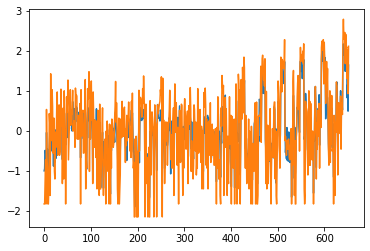

In [12]:
ax = plt.gca()
ax.plot(np.arange(0, yhat.shape[0]), yhat)
ax.plot(np.arange(0, yhat.shape[0]), y_data["y"].values)

In [13]:
smape(yhat,y_data["y"].values)

0.8871192299448318

In [14]:
mean_squared_error(yhat, y_data["y"].values)

0.25956857820546714

inverse transformed results:

In [15]:
yhat = transformer.inverse_transform(yhat.reshape(-1, 1)).flatten()

In [16]:
smape(yhat, transformer.inverse_transform(y_data["y"].values.reshape(-1, 1)).flatten())

0.5076926825793798

In [17]:
mean_squared_error(yhat, transformer.inverse_transform(y_data["y"].values.reshape(-1, 1)).flatten())

470.348497008163

In [18]:
az_inference = az.from_cmdstanpy(gp_model_fit, posterior_predictive="y_new_pred", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

In [19]:
az_inference

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [20]:
smape(yhat,y_data["y"].values)
smape(yhat,y_data["y"].values)
1.0763037108867184
mean_squared_error(yhat, y_data["y"].values)
0.4253616853756639
inverse transformed results

SyntaxError: invalid syntax (<ipython-input-20-5c31d69fb524>, line 6)